In [4]:
import os
from glob import glob
import random
#import time
import tensorflow
from tqdm import tqdm
import numpy as np
import pandas as pd
from IPython.display import FileLink,display,Image
import matplotlib.pyplot as plt
import warnings
import seaborn as sns 
%matplotlib inline
import matplotlib.image as mpimg
import cv2 
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_files
from sklearn.utils import shuffle
from sklearn.metrics import log_loss
from tensorflow import keras
from tensorflow.keras.utils import to_categorical
from keras.models import Sequential,Model
from keras.layers import Conv2D,MaxPooling2D,Flatten,Dense,Dropout,BatchNormalization,GlobalAveragePooling2D,concatenate,Input
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from keras.callbacks import ModelCheckpoint,EarlyStopping
from tensorflow.keras.models import Model
from tensorflow.keras.applications import InceptionV3,ResNet50
from tensorflow.keras.optimizers import Adam
from keras.models import load_model

In [5]:
dataset=pd.read_csv(r'C:\Users\master\Documents\mega_project\archive_2\driver_imgs_list.csv')
dataset.head(5)

subject classname            img
0    p012        c0  img_10206.jpg
1    p012        c0  img_27079.jpg
2    p012        c0  img_50749.jpg
3    p012        c0  img_97089.jpg
4    p012        c0  img_37741.jpg

In [6]:
NUMBER_CLASSES=10
#read with opencv 
def get_cv2_image(path,img_rows,img_cols,color_type=3):
    if color_type==1:
        img=cv2.imread(path,cv2.IMREAD_GRAYSCALE)
    elif color_type==3:
        img=cv2.imread(path,cv2.IMREAD_COLOR)
    img=cv2.resize(img,(img_rows,img_cols))
    return img

#loading training dataset
def load_train(img_rows,img_cols,color_type=3):
    train_imgs=[]
    train_labels=[]
    #loop over the training folder
    for classed in tqdm(range(NUMBER_CLASSES)):
        print('loading directory c{}'.format(classed))
        files=glob(os.path.join(r"C:\Users\master\Documents\mega_project\archive_2\imgs\train\c"+str(classed), '*.jpg'))
        for file in files:
            img=get_cv2_image(file,img_rows,img_cols,color_type)
            train_imgs.append(img)
            train_labels.append(classed)
    return train_imgs,train_labels

def read_and_normlize_train_data(img_rows,img_cols,color_type):
    X,labels=load_train(img_rows,img_cols,color_type)
    y=to_categorical(labels,10)
    x_train,x_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=42)
    x_train=np.array(x_train,dtype=np.uint8).reshape(-1,img_rows,img_cols,color_type)
    x_test=np.array(x_test,dtype=np.uint8).reshape(-1,img_rows,img_cols,color_type)
    return x_train,x_test,y_train,y_test

#loading validation dataset
def load_test(size=200000,img_rows=64,img_cols=64,color_type=3):
     path=os.path.join(r"C:\Users\master\Documents\mega_project\archive_2\imgs\test", '*.jpg')
     files=sorted(glob(path))
     X_test,X_test_id=[],[]
     total=0
     files_size=len(files)
     for file in tqdm(files):
         if total>=size or total>=files_size:
             break
         file_base=os.path.basename(file)
         img=get_cv2_image(file,img_rows,img_cols,color_type)
         X_test.append(img)
         X_test_id.append(file_base)
         total+=1
     return X_test,X_test_id

def read_and_normlize_sampled_test_data(size,img_rows,img_cols,color_type=3):
    test_data,test_ids=load_test(size,img_rows,img_cols,color_type)
    test_data=np.array(test_data,dtype=np.uint8)
    test_data=test_data.reshape(-1,img_rows,img_cols,color_type)
    return test_data,test_ids
    
    

In [7]:
img_rows=64
img_cols=64
color_type=1
nb_test_sample=200

#loading traing images
x_train,x_test,y_train,y_test=read_and_normlize_train_data(img_rows,img_cols,color_type)

#loading validation images
test_files,test_targets=read_and_normlize_sampled_test_data(nb_test_sample,img_rows,img_cols,color_type)

  0%|                                                                                           | 0/10 [00:00<?, ?it/s]

loading directory c0


 10%|████████▎                                                                          | 1/10 [00:07<01:04,  7.13s/it]

loading directory c1


 20%|████████████████▌                                                                  | 2/10 [00:13<00:53,  6.67s/it]

loading directory c2


 30%|████████████████████████▉                                                          | 3/10 [00:19<00:45,  6.51s/it]

loading directory c3


 40%|█████████████████████████████████▏                                                 | 4/10 [00:26<00:38,  6.44s/it]

loading directory c4


 50%|█████████████████████████████████████████▌                                         | 5/10 [00:32<00:31,  6.39s/it]

loading directory c5


 60%|█████████████████████████████████████████████████▊                                 | 6/10 [00:38<00:25,  6.38s/it]

loading directory c6


 70%|██████████████████████████████████████████████████████████                         | 7/10 [00:45<00:19,  6.54s/it]

loading directory c7


 80%|██████████████████████████████████████████████████████████████████▍                | 8/10 [00:50<00:12,  6.10s/it]

loading directory c8


 90%|██████████████████████████████████████████████████████████████████████████▋        | 9/10 [00:55<00:05,  5.81s/it]

loading directory c9


  4%|███▏                                                                          | 200/4961 [00:00<00:15, 309.28it/s]


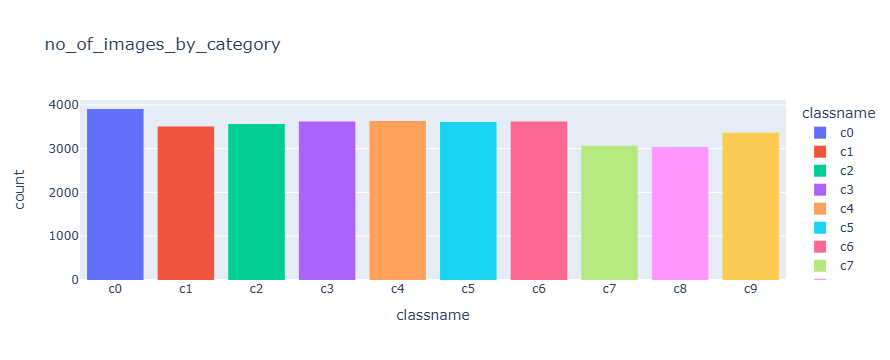

In [8]:
import plotly.express as px
px.histogram(dataset,x="classname",color="classname",title="no_of_images_by_category")

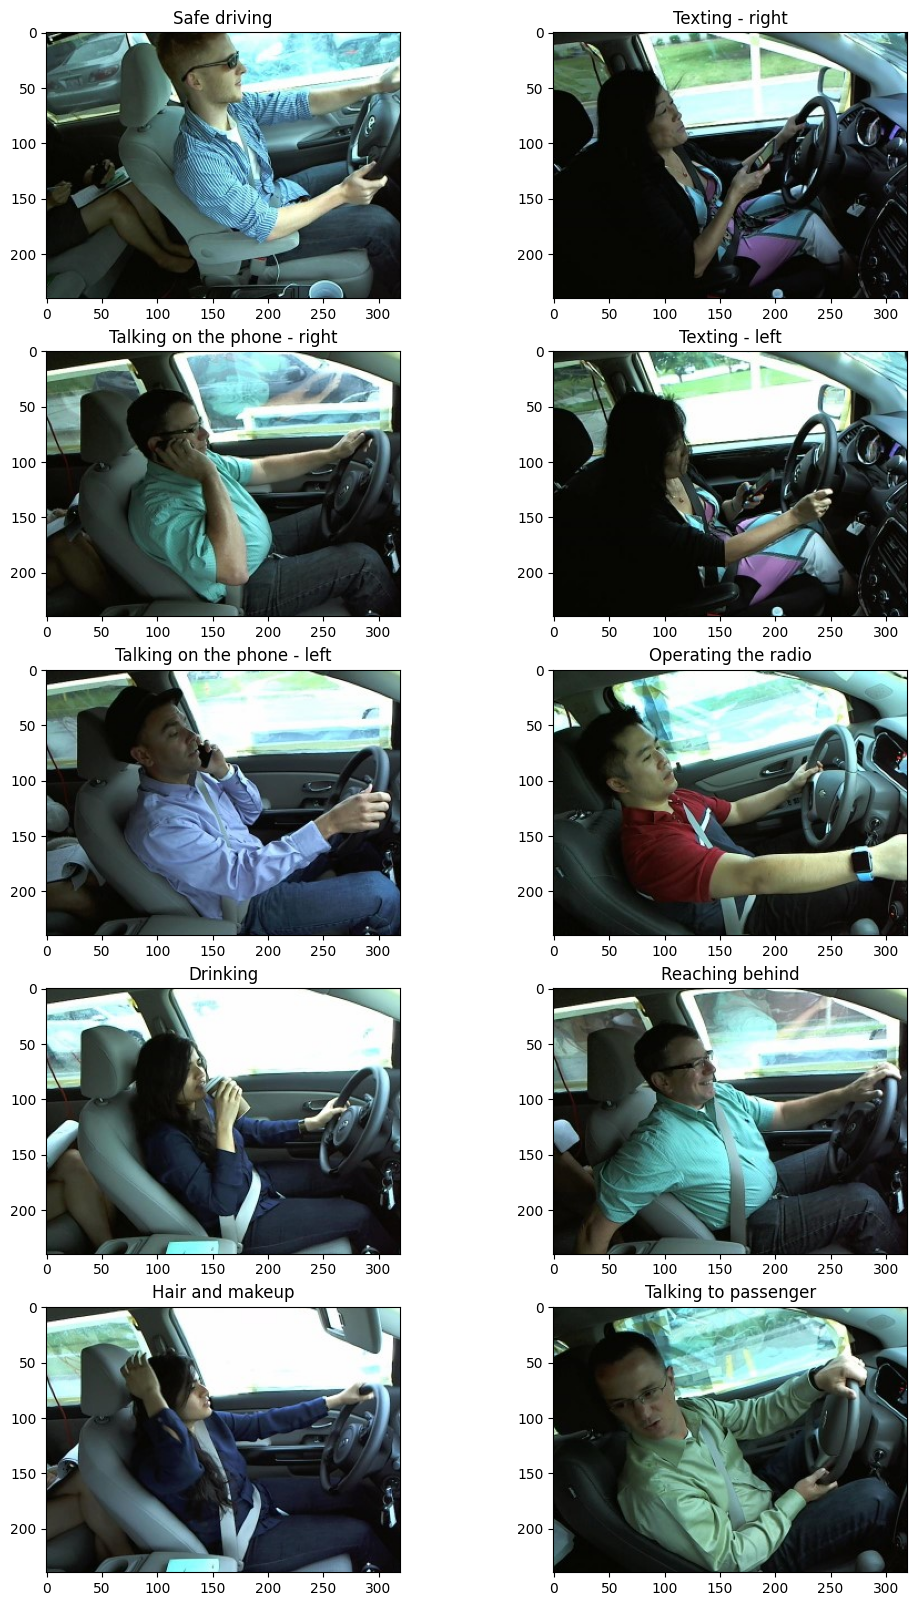

In [9]:
activity_map={
    'c0':'Safe driving',
    'c1':'Texting - right',
    'c2':'Talking on the phone - right',
    'c3':'Texting - left',
    'c4':'Talking on the phone - left',
    'c5':'Operating the radio',
    'c6':'Drinking',
    'c7':'Reaching behind',
    'c8':'Hair and makeup',
    'c9':'Talking to passenger',
}
plt.figure(figsize=(12,20))
image_count=1
base_url= "C:/Users/master/Documents/mega_project/archive_2/imgs/train/"


for directory in os.listdir(base_url):
    if directory[0]!='.':
        for i,file in enumerate(os.listdir(base_url+directory)):
            if i==1:
                break
            else:
                fig=plt.subplot(5,2,image_count)
                image_count+=1
                image=mpimg.imread(base_url+directory+'/'+file)
                plt.imshow(image)
                plt.title(activity_map[directory])
    
    

In [10]:
#inception model 

def create_inception_model():
    inputs = Input(shape=(img_rows, img_cols, color_type))
    
    tower_1 = Conv2D(32, (1, 1), padding='same', activation='relu')(inputs)
    tower_1 = Conv2D(32, (3, 3), padding='same', activation='relu')(tower_1)

    tower_2 = Conv2D(32, (1, 1), padding='same', activation='relu')(inputs)
    tower_2 = Conv2D(32, (5, 5), padding='same', activation='relu')(tower_2)

    tower_3 = MaxPooling2D((3, 3), strides=(1, 1), padding='same')(inputs)
    tower_3 = Conv2D(32, (1, 1), padding='same', activation='relu')(tower_3)

    x = concatenate([tower_1, tower_2, tower_3], axis=-1)
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Dropout(0.3)(x)

    x = Conv2D(64, (3, 3), padding='same', activation='relu')(x)
    x = BatchNormalization()(x)
    x = Conv2D(64, (3, 3), padding='same', activation='relu')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Dropout(0.3)(x)

    x = Conv2D(128, (3, 3), padding='same', activation='relu')(x)
    x = BatchNormalization()(x)
    x = Conv2D(128, (3, 3), padding='same', activation='relu')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Dropout(0.5)(x)

    x = Flatten()(x)
    x = Dense(512, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.25)(x)
    outputs = Dense(10, activation='softmax')(x)

    model = Model(inputs=inputs, outputs=outputs)
    return model

In [11]:
model = create_inception_model()

# More details about the layers
model.summary()

# Compiling the model
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])



Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 64, 64, 1)]          0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 64, 64, 32)           64        ['input_1[0][0]']             
                                                                                                  
 conv2d_2 (Conv2D)           (None, 64, 64, 32)           64        ['input_1[0][0]']             
                                                                                                  
 max_pooling2d (MaxPooling2  (None, 64, 64, 1)            0         ['input_1[0][0]']             
 D)                                                                                         

In [12]:
history=model.fit(x_train,y_train,validation_data=(x_test,y_test),epochs=15,batch_size=32,verbose=1)
model.save('C:/Users/master/Documents/mega_project/distraction_inception.h5')
val_loss,Accuracy=model.evaluate(x_test,y_test)
print(f"Accuracy={Accuracy*100:.2f}%")

Epoch 1/15


437/437 [==============================] - 404s 917ms/step - loss: 1.2905 - accuracy: 0.5787 - val_loss: 0.6226 - val_accuracy: 0.7944
Epoch 2/15
437/437 [==============================] - 415s 949ms/step - loss: 0.3832 - accuracy: 0.8767 - val_loss: 0.3028 - val_accuracy: 0.8964
Epoch 3/15
437/437 [==============================] - 381s 872ms/step - loss: 0.2358 - accuracy: 0.9271 - val_loss: 0.1553 - val_accuracy: 0.9585
Epoch 4/15
437/437 [==============================] - 386s 884ms/step - loss: 0.1731 - accuracy: 0.9502 - val_loss: 0.1014 - val_accuracy: 0.9791
Epoch 5/15
437/437 [==============================] - 397s 908ms/step - loss: 0.1316 - accuracy: 0.9592 - val_loss: 0.0859 - val_accuracy: 0.9831
Epoch 6/15
437/437 [==============================] - 383s 877ms/step - loss: 0.1146 - accuracy: 0.9665 - val_loss: 0.1298 - val_accuracy: 0.9751
Epoch 7/15
437/437 [==============================] - 388s 888ms/step - loss: 0.1024 - accuracy: 0.9699 - val_loss: 0.0587

C:\Python\lib\site-packages\keras\src\engine\training.py:3103: UserWarning:

You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.



110/110 [==============================] - 26s 235ms/step - loss: 0.0656 - accuracy: 0.9894
Accuracy=98.94%


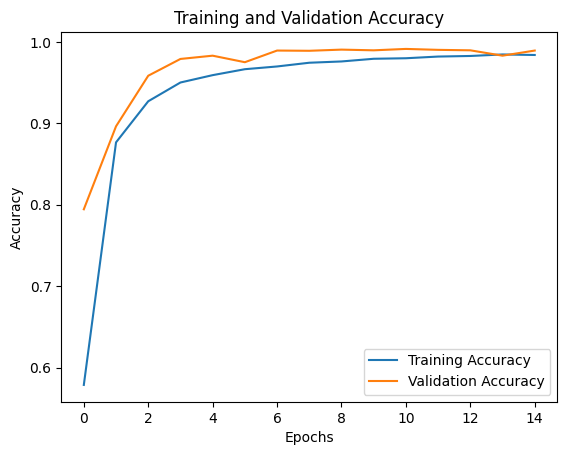

In [13]:
import matplotlib.pyplot as plt
# Plotting the training and validation accuracy over epochs
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()
